In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bootcamp/Test.csv
/kaggle/input/bootcamp/Train.csv
/kaggle/input/bootcamp/SampleSubmission.csv


In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold, TimeSeriesSplit, GroupKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('../input/bootcamp/Train.csv')
test = pd.read_csv('../input/bootcamp/Test.csv')
sub = pd.read_csv('../input/bootcamp/SampleSubmission.csv')

In [5]:
train.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,...,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,...,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,...,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,...,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,...,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,...,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


In [6]:
test.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,...,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,...,NaN,0.825000,1.01,0.800000,NaN,0.0,charge,NaN,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,...,18.8415,0.507694,4.04,0.623248,1.0,0.0,lending,NaN,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,NaN,NaN,NaN,charge,NaN,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,...,NaN,0.916663,2.02,0.464224,NaN,NaN,charge,90.163742,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,...,NaN,0.234047,23.23,0.726688,0.0,0.0,lending,1303.587148,1.637733,0.163124


In [7]:
sub.head()

,Applicant_ID,default_status
0,Apcnt_1000032,1
1,Apcnt_1000048,1
2,Apcnt_1000052,1
3,Apcnt_1000076,1
4,Apcnt_1000080,1


In [8]:
train["default_status"].replace({"no": 0, "yes": 1}, inplace=True)

In [9]:
len(train), len(test), len(sub)

(56000, 24000, 24000)

In [10]:
train.dtypes

Applicant_ID       object
form_field1       float64
form_field2       float64
form_field3       float64
form_field4       float64
form_field5       float64
form_field6       float64
form_field7       float64
form_field8       float64
form_field9       float64
form_field10      float64
form_field11      float64
form_field12      float64
form_field13      float64
form_field14        int64
form_field15      float64
form_field16      float64
form_field17      float64
form_field18      float64
form_field19      float64
form_field20      float64
form_field21      float64
form_field22      float64
form_field23      float64
form_field24      float64
form_field25      float64
form_field26      float64
form_field27      float64
form_field28      float64
form_field29      float64
form_field30      float64
form_field31      float64
form_field32      float64
form_field33      float64
form_field34      float64
form_field35      float64
form_field36      float64
form_field37      float64
form_field38

In [11]:
train.isnull().sum()

Applicant_ID          0
form_field1        2529
form_field2        3844
form_field3         355
form_field4         355
form_field5         355
form_field6       13360
form_field7        5163
form_field8       13360
form_field9        8008
form_field10        355
form_field11      31421
form_field12       9895
form_field13       5889
form_field14          0
form_field15      22475
form_field16      13036
form_field17      11151
form_field18      10402
form_field19          4
form_field20        355
form_field21      15854
form_field22      20400
form_field23      28123
form_field24      13297
form_field25       5450
form_field26       7438
form_field27       9299
form_field28        355
form_field29        355
form_field30      25509
form_field31      39408
form_field32       5450
form_field33       1256
form_field34        355
form_field35      23148
form_field36       1995
form_field37       5450
form_field38        355
form_field39       4211
form_field40      43729
form_field41    

In [12]:
#confirm if the dataset is balanced or imbalanced
len(train[train['default_status'] == 0]), len(train[train['default_status'] == 1])

(42285, 13715)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5]),
 <a list of 52 Text major ticklabel objects>)

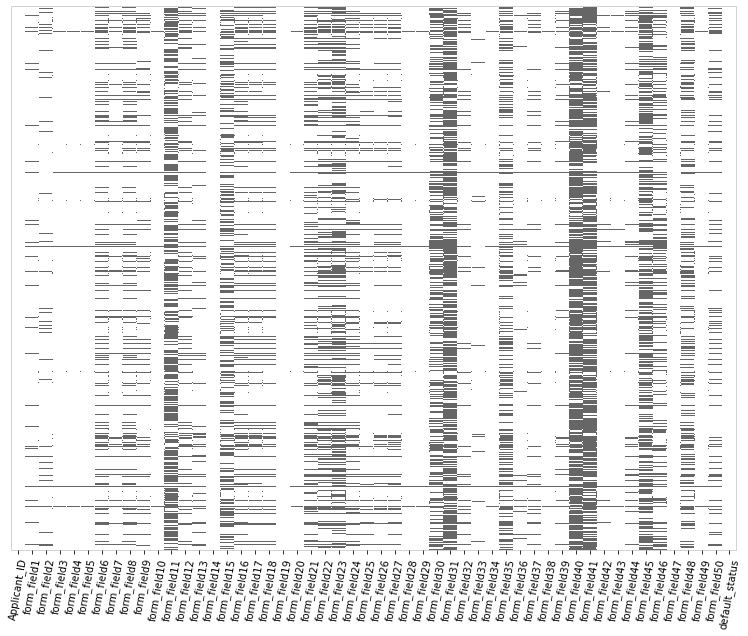

In [13]:
#given a dataframe train create a copy of the array that is 0 if a field contain a value and 1 for Nan
naInfo = np.zeros(train.shape)
naInfo[train.isna().values] = 1
naInfo = pd.DataFrame(naInfo, columns = train.columns)

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
ax = sns.heatmap(naInfo, vmin = 0, vmax = 1, cmap =['white', '#666666'], cbar = False, ax = ax)
ax.set_yticks([])

#draw frame around figure
rect = plt.Rectangle((0,0), naInfo.shape[1], naInfo.shape[0], linewidth = 1,
                     edgecolor = 'lightgrey', facecolor = 'none')
                     
rect = ax.add_patch(rect)
rect.set_clip_on(False)
                     
plt.xticks(rotation = 80)

In [14]:
##columns to drop are 'Applicant_ID','form_field11', 'form_field23', 'form_field31'
#'form_field40', 'form_field41', 'form_field45' from the train set
train.drop(columns = {'Applicant_ID'}, axis = 1, inplace = True)
test.drop(columns = {'Applicant_ID'}, axis = 1, inplace = True)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5]),
 <a list of 50 Text major ticklabel objects>)

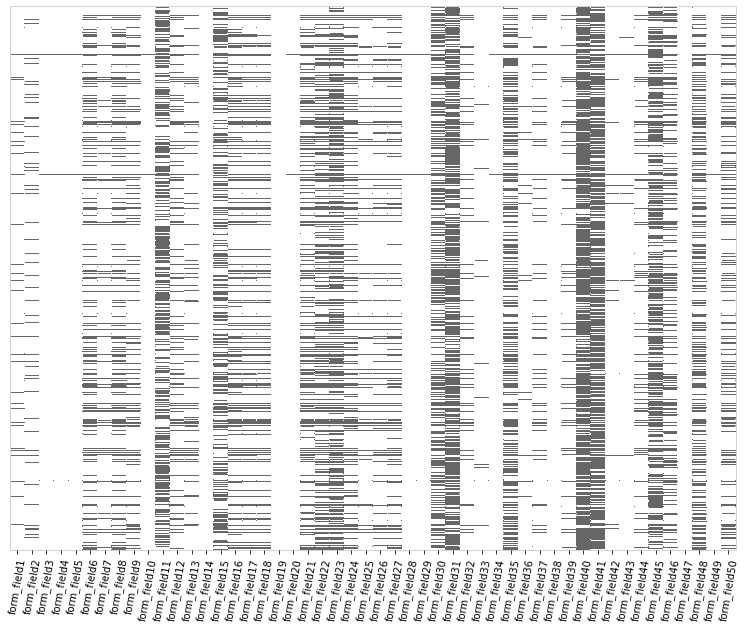

In [15]:
#given a dataframe train create a copy of the array that is 0 if a field contain a value and 1 for Nan
naInfo = np.zeros(test.shape)
naInfo[test.isna().values] = 1
naInfo = pd.DataFrame(naInfo, columns = test.columns)

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
ax = sns.heatmap(naInfo, vmin = 0, vmax = 1, cmap =['white', '#666666'], cbar = False, ax = ax)
ax.set_yticks([])

#draw frame around figure
rect = plt.Rectangle((0,0), naInfo.shape[1], naInfo.shape[0], linewidth = 1,
                     edgecolor = 'lightgrey', facecolor = 'none')
                     
rect = ax.add_patch(rect)
rect.set_clip_on(False)
                     
plt.xticks(rotation = 80)

In [16]:
train['form_field2'] = train['form_field2'] * 1000
train['form_field21'] = train['form_field21'] * 1000
train['form_field22'] = train['form_field22'] * 1000
train['form_field23'] = train['form_field23'] * 1000
train['form_field24'] = train['form_field24'] * 1000
train['form_field40'] = train['form_field40'] * 1000
train['form_field41'] = train['form_field41'] * 1000
train['form_field51'] = train['form_field1'] + train['form_field2']
train['form_field52'] = train['form_field3'] + train['form_field4'] + train['form_field5']
train['form_field53'] = train['form_field6'] + train['form_field7'] + train['form_field8'] + train['form_field9'] + train['form_field10'] + train['form_field11'] + train['form_field12'] + train['form_field13'] + train['form_field14'] + train['form_field15']

In [17]:
train['form_field54'] = train['form_field16'] + train['form_field17'] + train['form_field18'] + train['form_field19'] + train['form_field20']
train['form_field55'] = train['form_field26'] + train['form_field27']

In [18]:
test['form_field2'] = test['form_field2'] * 1000
test['form_field21'] = test['form_field21'] * 1000
test['form_field22'] = test['form_field22'] * 1000
test['form_field23'] = test['form_field23'] * 1000
test['form_field24'] = test['form_field24'] * 1000
test['form_field40'] = test['form_field40'] * 1000
test['form_field41'] = test['form_field41'] * 1000
test['form_field51'] = test['form_field1'] + test['form_field2']
test['form_field52'] = test['form_field3'] + test['form_field4'] + test['form_field5']
test['form_field53'] = test['form_field6'] + test['form_field7'] + test['form_field8'] + test['form_field9'] + test['form_field10'] + test['form_field11'] + test['form_field12'] + test['form_field13'] + test['form_field14'] + test['form_field15']

In [19]:
test['form_field54'] = test['form_field16'] + test['form_field17'] + test['form_field18'] + test['form_field19'] + test['form_field20'] 
test['form_field55'] = test['form_field26'] + test['form_field27']

In [20]:
train = train.fillna(-999)
test = test.fillna(-999)

In [21]:
train.shape, test.shape

((56000, 56), (24000, 55))

In [22]:
train.columns

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field47', 'form_field48',
       'form_field49', 'form_field50', 'default_status', 'form_field51',
       'form_field52', 'form_field53', 'form_field54', 'form_field55'],
      dtype=

In [23]:
test.columns

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field47', 'form_field48',
       'form_field49', 'form_field50', 'form_field51', 'form_field52',
       'form_field53', 'form_field54', 'form_field55'],
      dtype='object')

In [24]:
X = train.drop(columns=['default_status'])
y = train['default_status']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 24)

In [25]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [26]:
### Manual Hyperparameter Tuning
boost=CatBoostClassifier(class_weights = [1,1.4], n_estimators=1100, depth=6, l2_leaf_reg = 14, eval_metric = 'AUC', 
                         use_best_model = True)
boost.fit(train_X,train_y, cat_features = categorical_features_indices, eval_set = (valid_X, valid_y))

0:	test: 0.8121616	best: 0.8121616 (0)	total: 116ms	remaining: 2m 7s
1:	test: 0.8198783	best: 0.8198783 (1)	total: 165ms	remaining: 1m 30s
2:	test: 0.8227009	best: 0.8227009 (2)	total: 215ms	remaining: 1m 18s
3:	test: 0.8228322	best: 0.8228322 (3)	total: 263ms	remaining: 1m 11s
4:	test: 0.8232298	best: 0.8232298 (4)	total: 310ms	remaining: 1m 7s
5:	test: 0.8235620	best: 0.8235620 (5)	total: 360ms	remaining: 1m 5s
6:	test: 0.8245867	best: 0.8245867 (6)	total: 403ms	remaining: 1m 2s
7:	test: 0.8247572	best: 0.8247572 (7)	total: 447ms	remaining: 1m
8:	test: 0.8251841	best: 0.8251841 (8)	total: 490ms	remaining: 59.4s
9:	test: 0.8258428	best: 0.8258428 (9)	total: 536ms	remaining: 58.4s
10:	test: 0.8265172	best: 0.8265172 (10)	total: 587ms	remaining: 58.1s
11:	test: 0.8270512	best: 0.8270512 (11)	total: 634ms	remaining: 57.5s
12:	test: 0.8277283	best: 0.8277283 (12)	total: 680ms	remaining: 56.8s
13:	test: 0.8285458	best: 0.8285458 (13)	total: 722ms	remaining: 56s
14:	test: 0.8289610	best: 0.

In [27]:
valid_pred=boost.predict(valid_X)
print(classification_report(valid_y, valid_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     16963
           1       0.62      0.56      0.59      5437

    accuracy                           0.81     22400
   macro avg       0.74      0.72      0.73     22400
weighted avg       0.80      0.81      0.81     22400



In [28]:
#propensities on the validation set
valid_pred = boost.predict_proba(valid_X)
valid_pred =pd.DataFrame(valid_pred)
valid_pred.drop([0], axis = 1, inplace = True)

In [29]:
valid_y = pd.DataFrame(valid_y)

In [30]:
#calculate AUC
auc = roc_auc_score(valid_y, valid_pred)
print(auc)

0.849852844311171


In [31]:
#propensities on the test set
pred = boost.predict_proba(test)

In [32]:
pred = pd.DataFrame(pred)

In [33]:
pred.drop([0], axis = 1, inplace = True)

In [34]:
sub['default_status']  = pred

In [35]:
sub.to_csv('model_prob.csv', index = False)

In [36]:
train_X.shape,valid_X.shape

((33600, 55), (22400, 55))

In [37]:
train_y.shape, valid_y.shape

((33600,), (22400, 1))

In [38]:
X = train.drop(columns=['default_status'])
y = train['default_status']

In [39]:
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
i=1
for train_index, test_index in fold.split(X,y):
    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = y[train_index], y[test_index]
    m=CatBoostClassifier(n_estimators=1300,eval_metric='AUC',depth=5,scale_pos_weight= 1.4,l2_leaf_reg = 16,
                         bootstrap_type = 'Bernoulli', use_best_model=True)
    m.fit(train_X,train_y, cat_features = categorical_features_indices, eval_set=[(train_X,train_y),(valid_X, valid_y)], 
          early_stopping_rounds=250,verbose=100)
    preds=m.predict_proba(valid_X)[:, 1]
    print("err: ",roc_auc_score(valid_y,preds))
    errcb.append(roc_auc_score(valid_y,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

0:	test: 0.7805009	test1: 0.7770691	best: 0.7770691 (0)	total: 48.7ms	remaining: 1m 3s
100:	test: 0.8350527	test1: 0.8289591	best: 0.8289591 (100)	total: 4.42s	remaining: 52.4s
200:	test: 0.8410703	test1: 0.8335407	best: 0.8335407 (200)	total: 8.5s	remaining: 46.5s
300:	test: 0.8455174	test1: 0.8355243	best: 0.8355243 (300)	total: 12.5s	remaining: 41.4s
400:	test: 0.8496437	test1: 0.8369047	best: 0.8369047 (400)	total: 16.6s	remaining: 37.2s
500:	test: 0.8538181	test1: 0.8376580	best: 0.8376580 (500)	total: 20.7s	remaining: 33s
600:	test: 0.8576476	test1: 0.8384063	best: 0.8384143 (595)	total: 25s	remaining: 29s
700:	test: 0.8610109	test1: 0.8389064	best: 0.8389201 (695)	total: 29s	remaining: 24.8s
800:	test: 0.8641205	test1: 0.8390094	best: 0.8390247 (785)	total: 33s	remaining: 20.5s
900:	test: 0.8672322	test1: 0.8394444	best: 0.8394516 (898)	total: 37.3s	remaining: 16.5s
1000:	test: 0.8701787	test1: 0.8396413	best: 0.8396441 (998)	total: 41.3s	remaining: 12.3s
1100:	test: 0.8729289	t

In [40]:
np.mean(errcb)

0.8406891332658036

In [41]:
errcb1=[]
y_pred_totcb1=[]
fold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
i=1
for train_index, test_index in fold.split(X,y):
    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = y[train_index], y[test_index]
    m1=CatBoostClassifier(n_estimators=1700,eval_metric='AUC',depth=4,scale_pos_weight = 1.4,l2_leaf_reg = 16, 
                          use_best_model=True,bootstrap_type='Bayesian')
    m1.fit(train_X,train_y,cat_features = categorical_features_indices, eval_set=[(train_X,train_y),(valid_X, valid_y)], 
           early_stopping_rounds=250,verbose=100)
    preds=m1.predict_proba(valid_X)[:, 1]
    print("err: ",roc_auc_score(valid_y,preds))
    errcb1.append(roc_auc_score(valid_y,preds))
    p1 = m1.predict_proba(test)[:, 1]
    y_pred_totcb1.append(p1)

0:	test: 0.7832917	test1: 0.7824170	best: 0.7824170 (0)	total: 35.8ms	remaining: 1m
100:	test: 0.8317543	test1: 0.8270401	best: 0.8270401 (100)	total: 3.72s	remaining: 58.9s
200:	test: 0.8376378	test1: 0.8318742	best: 0.8318742 (200)	total: 7.79s	remaining: 58.1s
300:	test: 0.8415694	test1: 0.8342350	best: 0.8342350 (300)	total: 11.7s	remaining: 54.5s
400:	test: 0.8448805	test1: 0.8358806	best: 0.8358806 (400)	total: 15.5s	remaining: 50.2s
500:	test: 0.8477032	test1: 0.8367823	best: 0.8367823 (500)	total: 19.1s	remaining: 45.7s
600:	test: 0.8502254	test1: 0.8375427	best: 0.8375427 (600)	total: 22.8s	remaining: 41.6s
700:	test: 0.8524453	test1: 0.8380676	best: 0.8380676 (700)	total: 26.5s	remaining: 37.7s
800:	test: 0.8543051	test1: 0.8384943	best: 0.8384966 (799)	total: 30.2s	remaining: 33.9s
900:	test: 0.8561463	test1: 0.8387615	best: 0.8387666 (899)	total: 33.9s	remaining: 30.1s
1000:	test: 0.8580903	test1: 0.8390885	best: 0.8390927 (991)	total: 37.7s	remaining: 26.3s
1100:	test: 0.8

In [42]:
np.mean(errcb1)

0.8404856620935469

In [43]:
train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

In [44]:
X = train.drop(columns=['default_status'])
y = train['default_status']
#train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 24)

In [45]:
errcb2=[]
y_pred_totcb2=[]
fold=KFold(n_splits=5)
i=1
for train_index, test_index in fold.split(X,y):
    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = y[train_index], y[test_index]
    m2=XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=2150, scape_pos_weight = 1.4, silent=True, 
                     metrics='AUC',colsample_bylevel=0.8, reg_alpha=0.8)
    m2.fit(train_X,train_y,eval_set=[(train_X,train_y),(valid_X, valid_y)], early_stopping_rounds=250,verbose=100)
    preds=m2.predict_proba(valid_X)[:, 1]
    print("err: ",roc_auc_score(valid_y,preds))
    errcb2.append(roc_auc_score(valid_y,preds))
    p2 = m2.predict_proba(test)[:, 1]
    y_pred_totcb2.append(p2)

[12:07:47] WARNING: ../src/learner.cc:516: 
Parameters: { metrics, scape_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.20348	validation_1-error:0.21098
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 250 rounds.
[100]	validation_0-error:0.15455	validation_1-error:0.19518
[200]	validation_0-error:0.12730	validation_1-error:0.19366
[300]	validation_0-error:0.10424	validation_1-error:0.19357
[400]	validation_0-error:0.08600	validation_1-error:0.19616
Stopping. Best iteration:
[245]	validation_0-error:0.11714	validation_1-error:0.19179

err:  0.8337825833425261
[12:08:32] WARNING: ../src/learner.cc:516: 
Parameters: { metrics, scape_po

In [46]:
np.mean(errcb2)

0.8358456563796907

In [47]:
d = {"Applicant_ID": sub['Applicant_ID'], 'default_status': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Applicant_ID", 'default_status']]

In [48]:
test_predictions.to_csv('in40.csv', index = False)

In [49]:
test_predictions.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.382207
1,Apcnt_1000048,0.444894
2,Apcnt_1000052,0.494675
3,Apcnt_1000076,0.815815
4,Apcnt_1000080,0.244083


In [50]:
d = {"Applicant_ID": sub['Applicant_ID'], 'default_status': np.mean(y_pred_totcb1, 0)}
test_predictioned = pd.DataFrame(data=d)
test_predictioned = test_predictioned[["Applicant_ID", 'default_status']]

In [51]:
test_predictioned.to_csv('in41.csv', index = False)

In [52]:
test_predictioned.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.395296
1,Apcnt_1000048,0.432347
2,Apcnt_1000052,0.471471
3,Apcnt_1000076,0.809704
4,Apcnt_1000080,0.253750


In [53]:
d = {"Applicant_ID": sub['Applicant_ID'], 'default_status': np.mean(y_pred_totcb2, 0)}
test_prediction = pd.DataFrame(data=d)
test_prediction = test_prediction[["Applicant_ID", 'default_status']]

In [54]:
test_prediction.to_csv('in42.csv', index = False)

In [55]:
test_prediction.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.287659
1,Apcnt_1000048,0.401780
2,Apcnt_1000052,0.418887
3,Apcnt_1000076,0.712639
4,Apcnt_1000080,0.129364


In [56]:
a = pd.read_csv('model_prob.csv') 
b = pd.read_csv('in40.csv')
c = pd.read_csv('in41.csv')
d = pd.read_csv('in42.csv') 

In [57]:
d['default_status'].corr(a['default_status'])

0.9808695628371775

In [58]:
test_predictions['default_status'].corr(test_prediction['default_status'])

0.9873905523966362

In [59]:
test_predictions['default_status'] = (a['default_status'] + b['default_status'] + c['default_status'] + d['default_status'])/4 

In [60]:
test_predictions.to_csv('model_109_prob.csv', index = False)

In [61]:
test_predictions.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.358426
1,Apcnt_1000048,0.433927
2,Apcnt_1000052,0.457409
3,Apcnt_1000076,0.781088
4,Apcnt_1000080,0.202753


In [62]:
#This to check that the maximum probability is not greater than 1
test_predictions['default_status'].max()

0.9697656406124283

In [63]:
#This to check that the minimum probability is not less than 0
test_predictions['default_status'].min()

0.0026081432195230216

In [64]:
#score = 0.844411754893199